# 1. Preparaing the notebook
### Importing packages and libraries

In [22]:
# packages for data manipulation
import pandas as pd
import numpy as np
import seaborn as sns

# packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Reading file and tidying up columns

In [2]:
data = pd.read_csv("./Data/BankChurners.csv")

In [3]:
# dropping irrelevant columns
data = data.drop(columns=["CLIENTNUM", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1", "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"], axis=1)
data.head(1)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061


In [4]:
# tidy up and standardise column naming convention
tidied_cols = []
for col_name in data.columns:
    col_name = col_name.lower()
    if '_ct' in col_name:
        col_name = col_name.replace('_ct', '_count')
    if '_chng' in col_name:
        col_name = col_name.replace('_chng', '_change')
    tidied_cols.append( col_name )

data.columns = tidied_cols.copy()
data.columns

Index(['attrition_flag', 'customer_age', 'gender', 'dependent_count',
       'education_level', 'marital_status', 'income_category', 'card_category',
       'months_on_book', 'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_change_q4_q1', 'total_trans_amt',
       'total_trans_count', 'total_count_change_q4_q1',
       'avg_utilization_ratio'],
      dtype='object')

In [5]:
# retrieve categorical and numerical columns
numerical = list(data.describe().columns)
categorical = [i for i in data.columns if i not in numerical and i != "attrition_flag"]

### Splitting into train test split

In [6]:
y = data[["attrition_flag"]]
x = data.drop("attrition_flag", axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_age              10127 non-null  int64  
 1   gender                    10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   education_level           10127 non-null  object 
 4   marital_status            10127 non-null  object 
 5   income_category           10127 non-null  object 
 6   card_category             10127 non-null  object 
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  contacts_count_12_mon     10127 non-null  int64  
 11  credit_limit              10127 non-null  float64
 12  total_revolving_bal       10127 non-null  int64  
 13  avg_open_to_buy           10127 non-null  float64
 14  total_

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2021)

# 2. Data Cleaning

### Dropping columns with correlation

In [8]:
x_train = x_train.drop( columns=["customer_age", "avg_open_to_buy", "total_trans_count"] )
x_test = x_test.drop( columns=["customer_age", "avg_open_to_buy", "total_trans_count"] )

### Impute unknown values

In [9]:
def impute_unknown(df_x):
    """
        Imputes unknown values with their mode
    """
    x = df_x.copy()

    marital_status_mode = x["marital_status"].mode()[0]
    x["marital_status"] = x["marital_status"].replace("Unknown", marital_status_mode)
    education_level_mode = x["education_level"].mode()[0]
    x["education_level"] = x["education_level"].replace("Unknown", education_level_mode)
    income_category_mode = x["income_category"].mode()[0]
    x["income_category"] = x["income_category"].replace("Unknown", income_category_mode)
    
    return x

x_train = impute_unknown(x_train)
x_test = impute_unknown(x_test)

# 3. Feature Engineering

In [10]:
def feature_engineering(df_x, df_y):
    x = df_x.copy()
    y = df_y.copy()
    
    # Binary Encoding — features with binary categories  
    attrition_mapper = {"Existing Customer":0, "Attrited Customer":1}
    y["attrition_flag"] = y["attrition_flag"].replace(attrition_mapper)
    
    gender_mapper = {"F":0, "M":1}
    x["gender"] = x["gender"].replace(gender_mapper)
    
    # One Hot Encoding — features with nominal categories
    onehot_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    values = onehot_enc.fit_transform(x[["marital_status"]])
    labels = np.array(["divorced", "married", "single"]).ravel()
    marital_status_df = pd.DataFrame(values, columns=labels)

    x.reset_index(drop=True, inplace=True)
    marital_status_df.reset_index(drop=True, inplace=True)
    x = pd.concat([x, marital_status_df], axis=1)
    x.drop("marital_status", axis=1, inplace=True)
    
    # Ordinal Encoding — features with ordinal categories
    edu_level_mapper = {"Doctorate":1, "Post-Graduate":2, "Graduate":3, "College":4, "High School":5, "Uneducated":6}
    x["education_level"] = x["education_level"].replace(edu_level_mapper)

    income_cat_mapper = {"$120K +":1, "$80K - $120K":2, "$60K - $80K":3, "$40K - $60K":4, "Less than $40K":5}
    x["income_category"] = x["income_category"].replace(income_cat_mapper)

    card_cat_mapper = {"Platinum":1, "Gold":2, "Silver":3, "Blue":4}
    x["card_category"] = x["card_category"].replace(card_cat_mapper)
    
    return x, y

x_train, y_train = feature_engineering(x_train, y_train)
x_test, y_test = feature_engineering(x_test, y_test)

# 4. Feature Selection

## 4.1 Decision Tree
---

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

[Text(465.0, 755.0, 'total_count_change_q4_q1 <= 0.504\ngini = 0.27\nsamples = 8101\nvalue = [6799, 1302]\nclass = Existing Customer'),
 Text(232.5, 453.0, 'total_revolving_bal <= 599.5\ngini = 0.5\nsamples = 1263\nvalue = [643, 620]\nclass = Existing Customer'),
 Text(116.25, 151.0, 'gini = 0.328\nsamples = 499\nvalue = [103, 396]\nclass = Attrited Customer'),
 Text(348.75, 151.0, 'gini = 0.414\nsamples = 764\nvalue = [540, 224]\nclass = Existing Customer'),
 Text(697.5, 453.0, 'total_revolving_bal <= 577.5\ngini = 0.18\nsamples = 6838\nvalue = [6156, 682]\nclass = Existing Customer'),
 Text(581.25, 151.0, 'gini = 0.391\nsamples = 1642\nvalue = [1204, 438]\nclass = Existing Customer'),
 Text(813.75, 151.0, 'gini = 0.09\nsamples = 5196\nvalue = [4952, 244]\nclass = Existing Customer')]

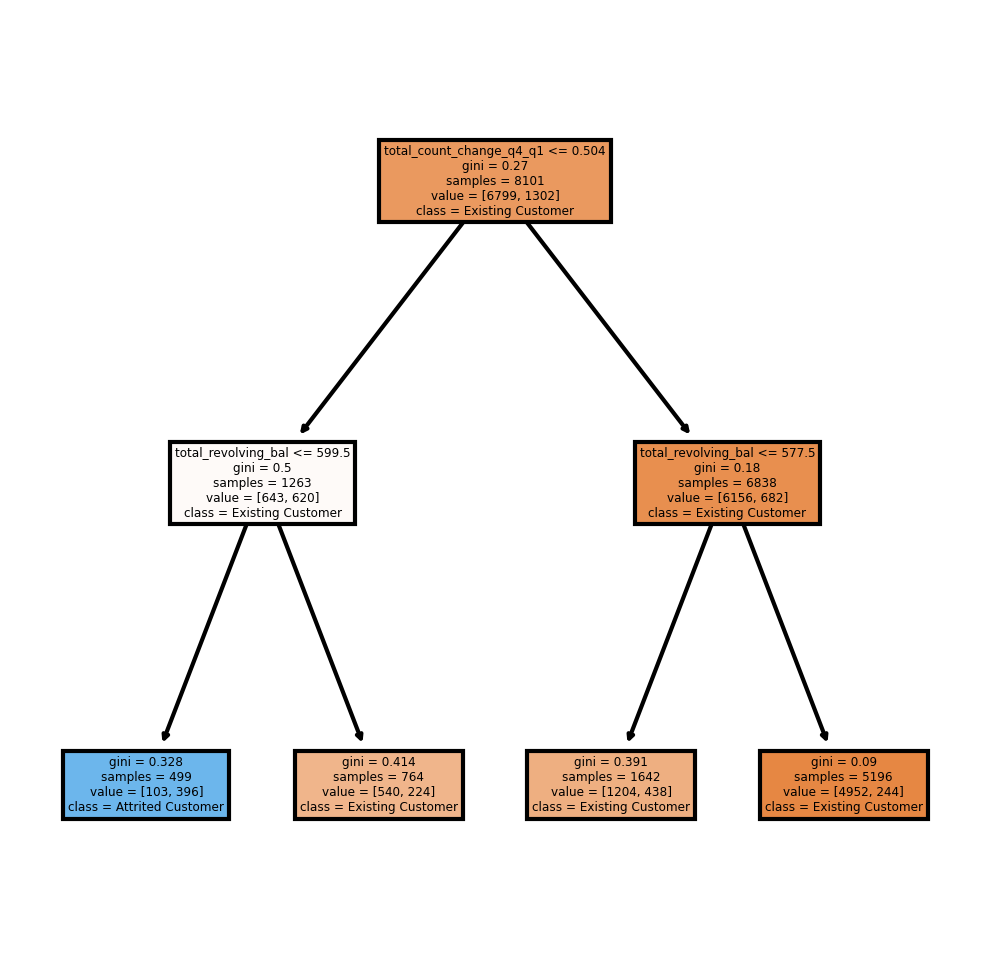

In [28]:
clf = DecisionTreeClassifier(max_depth=2, random_state=2021)
clf.fit(x_train, y_train)

class_labels = ['Existing Customer', 'Attrited Customer']
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = x_train.columns,
               class_names = class_labels,
               filled = True)

## 4.2 RandomForestClassifier
---

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=2021)
rf_clf.fit(x_train, y_train.values.ravel() )

RandomForestClassifier(n_estimators=1000, random_state=2021)

In [33]:
def retrieve_feature_importance(importance, names):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = {'feature_name':feature_names,'feature_importance':feature_importance}
    feature_importance_df = pd.DataFrame(data)

    feature_importance_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    return feature_importance_df.reset_index(drop=True)


feat_impt_df = retrieve_feature_importance(rf_clf.feature_importances_, x_train.columns)
feat_impt_df

,feature_name,feature_importance
0,total_trans_amt,0.240385
1,total_count_change_q4_q1,0.152683
2,total_revolving_bal,0.124880
3,total_amt_change_q4_q1,0.086418
4,avg_utilization_ratio,0.073904
5,total_relationship_count,0.064231
6,credit_limit,0.051072
7,months_on_book,0.045263
8,contacts_count_12_mon,0.039185
9,months_inactive_12_mon,0.034744


## 4.3 Lasso Regression
---

In [32]:
from sklearn.linear_model import Lasso

alpha_param = [1e-4, 1e-3, 1e-2, 1e-1, 1]

for alpha in alpha_param:
    lasso = Lasso(alpha=alpha)
    lasso.fit(x_train, y_train)

    importance = np.abs( lasso.coef_ )

    feat_impt_df = retrieve_feature_importance(importance, x_train.columns)
    feat_impt_df.index.rename('alpha='+str(alpha), inplace=True) 
    print( feat_impt_df )
    print()

                     feature_name  feature_importance
alpha=0.0001                                         
0                          rented        2.834742e-02
1                  marital_status        2.123702e-02
2                   car_ownership        1.564969e-02
3                           owned        5.941071e-03
4                      experience        2.235591e-03
5               current_job_years        8.618301e-04
6             current_house_years        5.383408e-04
7                             age        3.892070e-04
8                          income        2.928949e-10
9                    norent_noown        0.000000e+00
10             profession_encoded        0.000000e+00
11                   city_encoded        0.000000e+00
12                  state_encoded        0.000000e+00

                    feature_name  feature_importance
alpha=0.001                                         
0                         rented        1.961749e-02
1                  car_ownersh

## 4.4 XGBoost
---

In [69]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False,
                    random_state=2021)
                    
xgb.fit(x_train, y_train)

[22:53:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [70]:
feat_impt_df = retrieve_feature_importance(xgb.feature_importances_, x_train.columns)
feat_impt_df

,feature_name,feature_importance
0,total_relationship_count,0.154908
1,total_trans_amt,0.131090
2,total_revolving_bal,0.131048
3,total_count_change_q4_q1,0.108810
4,months_inactive_12_mon,0.066126
5,gender,0.053042
6,total_amt_change_q4_q1,0.052026
7,months_on_book,0.045863
8,contacts_count_12_mon,0.041815
9,married,0.035886


# 5. Feature Transformation and Feature Scaling

In [ ]:
def transformation_scaling(df_x, df_y):
    x = df_x.copy()
    y = df_y.copy()
    
    # Feature Transformation — Log Transformation for skewed data
    skewed = ["credit_limit", "total_amt_change_q4_q1", "total_trans_amt", "total_count_change_q4_q1"]

    for skewed_col in skewed:
        x[skewed_col] = np.log(x[skewed_col].mask(x[skewed_col] <=0)).fillna(0)

    # Feature Scaling - normalise features
    scaler = MinMaxScaler()
    x[numerical] = scaler.fit_transform(x[numerical]) 
    
    return x, y

x_train, y_train = transformation_scaling(x_train, y_train)
x_test, y_test = transformation_scaling(x_test, y_test)

# 4. Exporting preprocessed Train Test sets to csv files

In [ ]:
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)
try:
    train.to_csv("./Data/train.csv", index=False)
    test.to_csv("./Data/test.csv", index=False)
    print('Succesfully exported')
except:
    print('Error')